# TD8: Matrix inversion optimization around an example
*Prepared by Bruno Régaldo-Saint Blancard*

Solving linear systems $AX = B$ is generally a crucial step when solving PDEs. The choice of the right numerical method to do that can have a major impact on the performance of an algorithm both in terms of computational cost and memory cost. The structure and the properties of $A$ should determine the method.

In this TD, we will adress this issue through the example of a familiar problem: the 2D Laplace problem on a squared domain. The goal is to solve in an efficient way:
$$
    \begin{cases}
        \Delta f = 0 \text{ on } \Omega\\
        f = g \text{ on } \partial\Omega
    \end{cases}
$$
with  $\Omega = ]-\frac{L}{2}, \frac{L}{2}[^2$. In TD4, we used the 5-point stencil $\Delta_5$ to approximate the laplacian operator with finite-differences. We recall the definition of this stencil:
$$
\Delta_5 f (x, y) = \frac1{h^2}\left(f \left(x + h, y\right) + f \left(x - h, y\right) + f \left(x, y +h\right) + f\left(x, y -h\right) - 4f\left(x, y\right)\right)
$$

We also recall that we typically solve this problem in three steps:
1. Define a grid which covers $\Omega\cup\partial\Omega$ and is suitable for the chosen solving method.
2. Build the matrix which constrains the solution on the domain.
3. Find the inverse of this matrix to solve the problem.

We will first need the following Python packages for this TD:

In [1]:
# To draw matplotlib plots within this notebook.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

## Part 1: A naive algorithm

In TD4, we used a spatial grid $\mathcal{G}$ of size $N\times N$ defined by:
$$
    \mathcal{G} = \{(x_i = -L/2 + ih, y_j = -L/2 + jh), i = 0, ..., N - 1 \text{ and } j = 0, ..., N-1\} 
$$
with $h = \frac{L}{N-1}$ the spatial step.

On this grid, the 2D Laplace problem was rephrased in terms of two distinct set of constraints:
1. $\forall (x_i, y_j) \in \mathcal{G} \cap \Omega, \Delta_5 f(x_i, y_j) = 0$
2. $\forall (x_i, y_j) \in \mathcal{G} \backslash \Omega, f(x_i, y_j) = g(x_i, y_j)$

We turned these set of constraints into a linear system $AX=B$ where $A$ is a matrix of shape $(N \times N, N\times N)$ and $B$ is a column matrix of shape $(N \times N, 1)$, and we finally solved it using a LU solver namely  [scipy.linalg.lu_factor](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu_factor.html) and [scipy.linalg.lu_solve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu_solve.html) functions.

The following code implements this algorithm with $g(x,y)=\cos (2\pi(2x + y)/L)$:

In [2]:
def matrix_builder(N, L):
    x = np.linspace(-L/2, L/2, N)
    y = np.linspace(-L/2, L/2, N)
    
    # We define the grid with meshgrid function with a matrix indexing ('ij' parameter) so that distinct matrix rows correspond to distinct x coordinates
    # Similarly, distinct matrix columns also correspond to distinct y coordinates. 
    x_grid, y_grid = np.meshgrid(x, y, indexing='ij')
    
    A = np.zeros((N * N, N * N))
    B = np.zeros(N * N)
    
    def g(x, y):
        return np.cos(2*np.pi/L * (2*x + y))
    
    for i in range(x_grid.shape[0]):
        for j in range(x_grid.shape[1]):
            if np.abs(x_grid[i, j]) < L/2 and np.abs(y_grid[i, j]) < L/2: # We are inside \Omega
                A[i*N + j, i*N + j] = -4.0
                A[i*N + j, (i - 1)*N + j] = 1.0
                A[i*N + j, (i + 1)*N + j] = 1.0
                A[i*N + j, i*N + j + 1] = 1.0
                A[i*N + j, i*N + j - 1] = 1.0
            else: # We are outside \Omega
                A[i*N + j, i*N + j] = 1.0
                B[i*N + j] = g(x_grid[i, j], y_grid[i, j])
                
    return A, B

def matrix_solver(A, B):
    return la.lu_solve(la.lu_factor(A), B)

def plot_solution(N, L, X):
    h = L/(N - 1) # Becareful, h is not equal to L / N

    # We reshape X vector into a (N, N) matrix
    # Row indices correspond to different x coordinates, and columns indices to different y coordinates
    z_grid = X.reshape((N, N))
    
    # We will pay attention to the documentation of pcolor function to plot an accurate solution
    # We need: to avoid mixing x and y axis
    # We need: to define a grid of corner points instead of using directly x_grid and y_grid variables
    plt.figure()
    x_corner_points = np.linspace(-L/2 - h/2, L/2 + h/2, N + 1)
    y_corner_points = np.linspace(-L/2 - h/2, L/2 + h/2, N + 1)
    plt.pcolor(x_corner_points, y_corner_points, z_grid.T, cmap='jet')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title("Laplace equation with a 5-point stencil")
    plt.show()
    
def naive_solver(N, L, plot=False):
    A, B = matrix_builder(N, L)
    X = matrix_solver(A, B)
    if plot:
        plot_solution(N, L, X)

**1)** Using the previous *naive_solver* function, solve this 2D Laplace problem for arbitrary values of $N$ and $L$. We will also plot the solution.

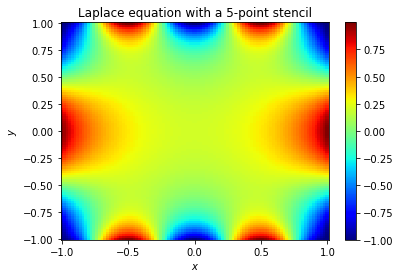

In [3]:
naive_solver(100, 2.0, plot=True)

**2)** What is the most computationally expensive part of the previous code in terms of CPU operations? Deduce from this the complexity of this algorithm as a function of $N$.

<span style="color:red">**Answer:**<br/><br/>
The most computationnally expensive part of the previous code is the solver of the linear system, meaning the *matrix_solver* function. Indeed, the complexity of a standard LU factorization is a $\mathcal{O}(M^3)$ where $M$ is the size of the matrix to be factorized.
</span>

**3)** How should evolve the memory cost of this algorithm with $N$?

<span style="color:red">**Answer:**<br/><br/>
The memory cost in this algorithm is dominated by the huge size of the matrix $A$. The shape of $A$ is $(N\times N,N\times N)$, thus to store its coefficients we need $8N^4$ bytes (using *float64* numbers). Therefore, the memory cost of this algorithm is roughly proportional to $N^4$.
</span>

**4)** Measure the runtime of the previous algorithm for a reasonable range of $N$ values. We will plot our measures on a log-log scale. We will use successive calls of [time.time](https://docs.python.org/3/library/time.html#time.time) function to measure the runtime.

Solving problem for N = 20...
Solving problem for N = 30...
Solving problem for N = 40...
Solving problem for N = 50...
Solving problem for N = 60...
Solving problem for N = 70...
Solving problem for N = 80...
Solving problem for N = 90...
Solving problem for N = 100...
Solving problem for N = 110...
Solving problem for N = 120...
Solving problem for N = 130...
Solving problem for N = 140...


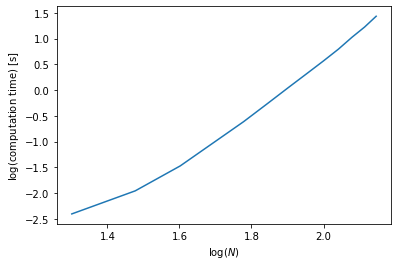

In [4]:
import time

computation_time = []
for N in range(20, 150, 10):
    print("Solving problem for N = " + str(N) + "...")
    start_time = time.time()
    naive_solver(N, 1.0, plot=False)
    end_time = time.time()
    computation_time.append([N, end_time - start_time])
computation_time = np.array(computation_time)

plt.figure()
plt.plot(np.log10(computation_time[:, 0]), np.log10(computation_time[:, 1]))
plt.xlabel(r'$\log(N)$')
plt.ylabel(r'$\log$(computation time) [s]')
plt.show()

**5)** You should observe an asymptotic linear trend on the previous plot. Using [scipy.stats.linregress](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) measure the slope of this linear trend. Is this what you were expecting?

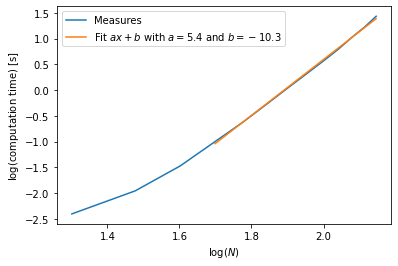

In [5]:
import scipy.stats as stats

x = np.log10(computation_time[:, 0])
y = np.log10(computation_time[:, 1])
logN_fit_threshold = np.log10(40)

(a, b, rho, _, _) = stats.linregress(x[x > logN_fit_threshold], y[x > logN_fit_threshold])

plt.figure()
plt.plot(x, y, label='Measures')
plt.plot(x[x > logN_fit_threshold], a * x[x > logN_fit_threshold] + b, label='Fit $ax+b$ with $a = ' + '{0:.1f}'.format(a) + '$ and $b = ' + '{0:.1f}'.format(b) + '$')
plt.xlabel(r'$\log(N)$')
plt.ylabel(r'$\log$(computation time) [s]')
plt.legend()
plt.show()

<span style="color:red">**Answer:**<br/><br/>
We get a slope which is close to $6$ (and should be closer to this value if we make measures for larger $N$), this is consistent with the expected time complexity of LU factorization which should be a $\mathcal{O}(N^6)$.
</span>

**6)** We have been solving the linear system $AX=B$ with a common LU factorization, but there are much smarter ways to do that in this specific case. What can you tell about the structure of the $A$ matrix we built with *matrix_builder* function? We will visualize $A$ matrix with [pyplot.matshow](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.matshow.html) function.

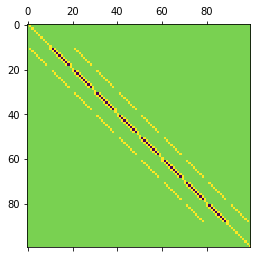

In [6]:
A, B = matrix_builder(10, 1.0)
plt.matshow(A)

<span style="color:red">**Answer:**<br/><br/>
We can see that matrix $A$ is a banded matrix of bandwith $N$ which only has 4 non-zero diagonals.
</span>

## Part 2: Sparse representations of matrices

The previous matrix $A$ is a banded matrix with 4 non-zero diagonals only, meaning that the number of non zero coefficients is highly negligible compared to the number of zero coefficients when $N$ is big enough. We call such a matrix a *sparse matrix* and we certainly can make use of that outstanding property...

The [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html) package gives us handy functions to define and manipulate these sparse matrices.

**7)** Build a tridiagonal matrix $A$ with coefficients on the main diagonal equal to 1, and coefficients on the first diagonals above and below the main diagonal equal to 2. We will use [scipy.sparse.diags](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.diags.html#scipy.sparse.diags) function to build this matrix, and we will plot it with [pyplot.matshow](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.matshow.html) function.

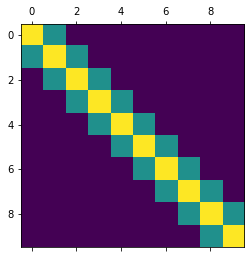

In [7]:
import scipy.sparse as sparse

N = 10
A = sparse.diags([2*np.ones(N), np.ones(N - 1), np.ones(N - 1)], offsets=[0, 1, -1])
plt.matshow(A.toarray())

**8)** Now let us go back to our 2D Laplace problem. On the model of the code of part 1, define the following new set of functions:
* *sparse_matrix_builder* function which builds $A$ and $B$ matrices using sparse data structures from *scipy.sparse* package (at least for $A$ matrix)
* *sparse_matrix_solver* function which solves the linear system $AX=B$ for sparse matrices using [scipy.sparse.linalg.spsolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.spsolve.html#scipy.sparse.linalg.spsolve) function
* *sparse_solver* function which actually solves our 2D Laplace problem using these previous functions

/home/bruno/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


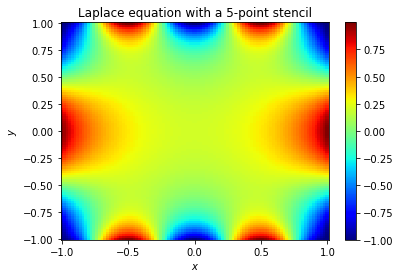

In [8]:
import scipy.sparse.linalg as splinalg

def sparse_matrix_builder(N, L):
    x = np.linspace(-L/2, L/2, N)
    y = np.linspace(-L/2, L/2, N)
    
    # We define the grid with meshgrid function with a matrix indexing ('ij' parameter) so that distinct matrix rows correspond to distinct x coordinates
    # Similarly, distinct matrix columns also correspond to distinct y coordinates.
    x_grid, y_grid = np.meshgrid(x, y, indexing='ij')
    
    diag_0 = np.zeros(N * N)
    diag_1 = np.zeros(N * N - 1)
    diag_1m = np.zeros(N * N - 1)
    diag_N = np.zeros(N * (N - 1))
    diag_Nm = np.zeros(N * (N - 1))
    B = np.zeros(N * N)
    
    def g(x, y):
        return np.cos(2*np.pi/L * (2*x + y))
    
    for i in range(x_grid.shape[0]):
        for j in range(x_grid.shape[1]):
            if np.abs(x_grid[i, j]) < L/2 and np.abs(y_grid[i, j]) < L/2: # We are inside \Omega
                diag_0[i*N + j] = -4.0
                diag_1[i*N + j] = 1.0
                diag_1m[i*N + j - 1] = 1.0
                diag_N[i*N + j] = 1.0
                diag_Nm[i*N + j - N] = 1.0
            else: # We are outside \Omega
                diag_0[i*N + j] = 1.0
                B[i*N + j] = g(x_grid[i, j], y_grid[i, j])
                
    return sparse.diags([diag_0, diag_1, diag_1m, diag_N, diag_Nm], offsets=[0, 1, -1, N, -N]), B

def sparse_matrix_solver(A, B):
    return splinalg.spsolve(A, B)

def sparse_solver(N, L, plot=False):
    A, B = sparse_matrix_builder(N, L)
    X = sparse_matrix_solver(A, B)
    if plot:
        plot_solution(N, L, X)

sparse_solver(100, 2.0, plot=True)

**9)** Now, how should evolve the memory cost of this algorithm with $N$?

<span style="color:red">**Answer:**<br/><br/>
Now, the storage of the matrix $A$ coefficients only demand to store the coefficients of non-zero diagonals and the positions of these non-zero diagonals. The memory cost of this algorithm should now be roughly proportional to $N^2$ (compared to $N^4$ in the first part!).
</span>

**10)** Measure the time complexity of this new algorithm on the model of what we did in the first part.

Solving problem for N = 20...
Solving problem for N = 30...
Solving problem for N = 40...
Solving problem for N = 50...
Solving problem for N = 60...
Solving problem for N = 70...
Solving problem for N = 80...
Solving problem for N = 90...
Solving problem for N = 100...
Solving problem for N = 110...
Solving problem for N = 120...
Solving problem for N = 130...
Solving problem for N = 140...
Solving problem for N = 150...
Solving problem for N = 160...
Solving problem for N = 170...
Solving problem for N = 180...
Solving problem for N = 190...
Solving problem for N = 200...
Solving problem for N = 210...
Solving problem for N = 220...
Solving problem for N = 230...
Solving problem for N = 240...
Solving problem for N = 250...
Solving problem for N = 260...
Solving problem for N = 270...
Solving problem for N = 280...
Solving problem for N = 290...
Solving problem for N = 300...
Solving problem for N = 310...
Solving problem for N = 320...
Solving problem for N = 330...
Solving problem 

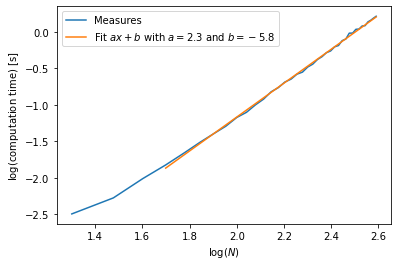

In [9]:
computation_time = []
for N in range(20, 400, 10):
    print("Solving problem for N = " + str(N) + "...")
    start_time = time.time()
    sparse_solver(N, 1.0, plot=False)
    end_time = time.time()
    computation_time.append([N, end_time - start_time])
computation_time = np.array(computation_time)

x = np.log10(computation_time[:, 0])
y = np.log10(computation_time[:, 1])

logN_fit_threshold = np.log10(40)

(a, b, rho, _, _) = stats.linregress(x[x > logN_fit_threshold], y[x > logN_fit_threshold])

plt.figure()
plt.plot(x, y, label='Measures')
plt.plot(x[x > logN_fit_threshold], a * x[x > logN_fit_threshold] + b, label='Fit $ax+b$ with $a = ' + '{0:.1f}'.format(a) + '$ and $b = ' + '{0:.1f}'.format(b) + '$')
plt.xlabel(r'$\log(N)$')
plt.ylabel(r'$\log$(computation time) [s]')
plt.legend()
plt.show()

<span style="color:red">**Answer:**<br/><br/>
We see that in this case, the time complexity of this algorithm is a $\mathcal{O}(N^{2.3})$, which is a tremendous complexity improvement compared to part 1 algorithm!
</span>